In [1]:
import pandas as pd
import numpy as np
import datasets
from datasets import Dataset, load_dataset

In [2]:
# the code is adapted from the "fine-tuning a pretrained model" and
# "fine-tuning a model with the trainer API" course and examples on hugging face
# check huggingface for further explanations

# load data into training, valdidation and test
dataset = load_dataset('csv', data_files={'train':['hansen_p_bert_ds1.csv', 'hansen_p_bert_ds2.csv',
                                                   'hansen_p_bert_ds3.csv', 'hansen_p_bert_ds4.csv'],
                                          'validation':'hansen_p_bert_ds5.csv',
                                          'test': 'hansen_p_bert_ds6.csv'}, delimiter=',', column_names =['smiles', 'label'])

Using custom data configuration default-c8b2b21fcaf52a91


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/pj11/.cache/huggingface/datasets/csv/default-c8b2b21fcaf52a91/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# check data format
dataset['validation'][1]

{'smiles': 'CC\\C(C)=N\\O', 'label': 4.9}

In [4]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

# specify model from hugging face
tokenizer = AutoTokenizer.from_pretrained("deepchem/ChemBERTa-77M-MTR")

def tokenize_function(examples):
    return tokenizer(examples["smiles"], padding="max_length", truncation=True)

In [5]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [6]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 789
    })
    validation: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 197
    })
    test: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 197
    })
})

In [7]:
#small_train_dataset = tokenized_datasets["train"].shuffle(seed=random_state).select(range(1000))
#small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=random_state).select(range(1000))

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["validation"]
small_test_dataset = tokenized_datasets["test"]

In [8]:
# for regression, num_labels=1
model = AutoModelForSequenceClassification.from_pretrained("deepchem/ChemBERTa-77M-MTR", num_labels=1)

Some weights of the model checkpoint at deepchem/ChemBERTa-77M-MTR were not used when initializing RobertaForSequenceClassification: ['regression.out_proj.bias', 'norm_mean', 'regression.dense.weight', 'regression.out_proj.weight', 'norm_std', 'regression.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at deepchem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bia

In [9]:
import evaluate
import numpy as np

In [10]:
# define metric
mae_metric = evaluate.load("mae")
mse_metric = evaluate.load("mse")
pearsonr_metric = evaluate.load("pearsonr")

def compute_metrics(eval_pred):
    # print(eval_pred)
    #logits, labels = eval_pred
    #predictions = np.argmax(logits, axis=-1)
    predictions, labels = eval_pred
    
    metrics = {}
    metrics.update({'mae': mae_metric.compute(predictions=predictions, references=labels)})
    metrics.update({'rmse': mse_metric.compute(predictions=predictions, references=labels, squared=False)})
    metrics.update({'pearsonr': pearsonr_metric.compute(predictions=predictions, references=labels)})
    
    return metrics

In [11]:
# directory to save the finetuned model
para_output_dir = 'C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1/'
model_output_path = f'{para_output_dir}/model'

# specify trainining arguments 
training_args = TrainingArguments(output_dir=para_output_dir, 
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size = 4,
                                  per_device_eval_batch_size = 4,
                                  num_train_epochs=100)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

In [13]:
# finetuning
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 789
  Num Epochs = 100
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5000
  Number of trainable parameters = 3427825
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Wa

Epoch,Training Loss,Validation Loss,Mae,Rmse,Pearsonr
1,No log,32.999813,{'mae': 4.3853575911770015},{'mse': 5.760618738828536},{'pearsonr': 0.1432079271172701}
2,No log,16.771713,{'mae': 3.1292016028147662},{'mse': 4.115499259915974},{'pearsonr': 0.13694972432990407}
3,No log,15.200443,{'mae': 2.9508277680063006},{'mse': 3.9190619062333707},{'pearsonr': 0.3498915673311254}
4,No log,13.657250,{'mae': 2.8312507141665155},{'mse': 3.7160847692847656},{'pearsonr': 0.4506257399402354}
5,No log,13.304548,{'mae': 2.804424956365285},{'mse': 3.666908555979194},{'pearsonr': 0.4957232410087511}
6,No log,12.555748,{'mae': 2.7788217200845633},{'mse': 3.5627072981410435},{'pearsonr': 0.5153311041063423}
7,No log,12.098452,{'mae': 2.711085844766065},{'mse': 3.4961353100647568},{'pearsonr': 0.5571548359727206}
8,No log,11.049445,{'mae': 2.6310947013990527},{'mse': 3.3423437555186846},{'pearsonr': 0.5902452468381787}
9,No log,10.809216,{'mae': 2.580661134671439},{'mse': 3.304431414538389},{'pearsonr': 0.6148517953146416}
10,19.116300,10.579213,{'mae': 2.6097256045051034},{'mse': 3.267475578774824},{'pearsonr': 0.6165920289982403}


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\ncc

Saving model checkpoint to C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1/checkpoint-1500
Configuration saved in C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1/checkpoint-1500\config.json
Model weights saved in C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1/checkpoint-1500\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-pack

***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
Saving model checkpoint to C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1/checkpoint-2000
Configuration saved in C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1/checkpoint-2000\config.json
Model weights saved in C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1/checkpoint-2000\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
Saving model checkpoint to C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1/checkpoint-2500
Configuration saved in C:/Users/pj11/Documents/bert_finetune2/hansen_p_f

***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: Use

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: Use

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: Use

TrainOutput(global_step=5000, training_loss=6.20960732421875, metrics={'train_runtime': 574.8886, 'train_samples_per_second': 137.244, 'train_steps_per_second': 8.697, 'total_flos': 726968128204800.0, 'train_loss': 6.20960732421875, 'epoch': 100.0})

In [14]:
#take care of distributed/paralelle training 
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model 
model_to_save.save_pretrained(model_output_path)

Configuration saved in C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1//model\config.json
Model weights saved in C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1//model\pytorch_model.bin


In [15]:
# making prediction 
model = AutoModelForSequenceClassification.from_pretrained(model_output_path)

# arguments for Trainer
test_args = TrainingArguments(
     output_dir =model_output_path,
     do_train = False,
     do_predict = True,
     dataloader_drop_last = False
)

# Init Trainer
trainer=Trainer(
          model = model,
          args = test_args,
          compute_metrics = compute_metrics)

test_results = trainer.predict(small_test_dataset)

loading configuration file C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1//model\config.json
Model config RobertaConfig {
  "_name_or_path": "C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1//model",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.109,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.144,
  "hidden_size": 384,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 464,
  "is_gpu": true,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 515,
  "model_type": "roberta",
  "norm_mean": [
    11.199569164274653,
    -0.9728601944583675,
    11.199595401578872,
    0.1914454376660732,
    0.608589373135307,
    365.064017672,
    342.24912812000014,
    364.6033136038417,
    134.06547,
    0.004249,
    0.0,
    0.0,
    0.

loading weights file C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1//model\pytorch_model.bin
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at C:/Users/pj11/Documents/bert_finetune2/hansen_p_fold1//model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected

In [16]:
# print out prediction in test set
test_results[1]

array([ 8.9,  0. ,  0.8,  0. ,  2.2,  7.3, 18.8,  1.8,  9. ,  1.7,  0.6,
        4.1,  1.7, 18. ,  7.1,  4.1,  5.4,  9.7,  7. , 14. ,  6.9,  7. ,
        7. ,  4.7, 15.5, 14.8,  4.7,  6.5, 15.3, 11. ,  1. ,  5.1, 19.8,
        1.6,  7.9,  7.6,  4.9, 10.6,  7.2,  7. ,  6.3,  5.9,  9.9,  6.1,
        3.3,  4.1,  9.9,  6.1,  5.7,  4.8,  7.2, 20.5,  8.5,  5.2, 10.4,
        9.6,  0. ,  6.1,  0. ,  7.9,  6.5,  4.1,  3.9,  7.6,  8. ,  8.9,
        0. , 10.6,  9.2,  7.5,  4. ,  3.4,  8.7, 17.4,  2. ,  6.8,  5.6,
       10.3, 10. ,  4.9,  4.3,  0. ,  8.9,  9.3,  7.5,  4.3, 15.5,  5. ,
       13.1, 12.5,  2.6,  6. ,  6.4,  8.1,  3.7,  8.5,  6.2,  9.1,  9.2,
        7. ,  9.2,  8.4,  4.3,  5. ,  8.2,  8.7,  6.1,  4.6, 12.8,  8. ,
       16. , 13.7,  1. ,  0.1,  8.8,  6.9,  5.5, 10.3,  7.7,  7.6,  1.8,
       16.7,  4.9,  6.2,  3.1,  0. ,  6.2,  4.4,  0. ,  1.6, 10.3,  7.6,
        0.1,  1.7,  0. ,  2.4, 11.2, 10.7,  4.2, 19.5, 12.4,  1.8,  3.4,
       16.2,  0. , 11.3,  3.7,  6.1,  3.1,  6.5,  5

In [17]:
# print out metric in test set
test_results[2]

{'test_loss': 11.0779390335083,
 'test_mae': {'mae': 2.2994369157982355},
 'test_rmse': {'mse': 3.328163097223352},
 'test_pearsonr': {'pearsonr': 0.7043356767778755},
 'test_runtime': 0.8898,
 'test_samples_per_second': 221.394,
 'test_steps_per_second': 7.867}

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

# MAE, AE and RMSE give an idea of the error distribution
print(mean_absolute_error(test_results[0], test_results[1]))

#RMSEs
print(math.sqrt(mean_squared_error(test_results[0], test_results[1])))

# R^2 Coefficient of Determination
print(r2_score(test_results[0], test_results[1]))

2.299437
3.3281631109356953
0.33353279924017853


Text(0, 0.5, 'pred. Hansen p')

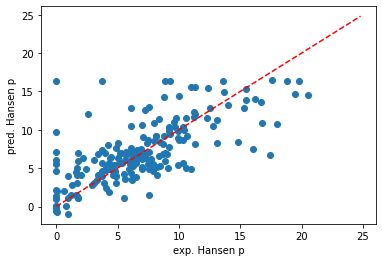

In [19]:
# plot exp vs pred in test set
import matplotlib.pyplot as plt
plt.figure(1)

ln = np.arange(0, 25, 0.2)
plt.plot(ln, ln,'r--')
plt.scatter(test_results[1], test_results[0])
plt.xlabel('exp. Hansen p')
plt.ylabel('pred. Hansen p')

In [20]:
pd_pred_test=pd.DataFrame(test_results[0], columns=["predict"])
pd_exp_test=pd.DataFrame(test_results[1], columns=["exp"])
pd_smiles=pd.DataFrame(dataset['test']['smiles'], columns=["smiles"])
pd_test=pd.concat((pd_smiles, pd_exp_test, pd_pred_test), axis=1)

# save predicton to csv 
pd_test.to_csv('hansen_p_bert_ds6_fold1_results.csv')

In [ ]:
pd_test